In [1]:
import tensorflow as tf

from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import cv2
import os
import uuid
import tempfile

import mlflow
import mlflow.tensorflow
import mlflow.keras

import xebikart.dataset as dataset
from xebikart.vae import create_variational_auto_encoder, custom_vae_loss
import xebikart.images.transformer as images_transformer

using donkey version: 2.5.8 ...


In [2]:
# parameters
learning_rate = 1e-4
batch_size = 64
n_epochs = 10

# Vae parameters
latent_dim = 32

# Images
image_root_folder = "file:/workspace/xebikart-ml-tubes"
image_folders = [
  "tub.v1.03",
  "tub.v1.04",
  "tub.v1.05",
  "tub.v2.01",
  "tub.v4.02",
  "tub.v4.03"
]

## Utils

In [17]:
def plot_images(images, title):
    n = len(images)
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(images[i][:,:,0],cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(images[i][:,:,1],cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

**Images will be :**
- Loaded
    - Read images
    - Decode jpeg images into uint8 tensor
- Cropped
    - Crop images on the lower part
- Augmented
    - Brightness : Adjust the brightness of images by a random factor.
    - Saturation : Adjust the saturation of images by a random factor (must be RGB images)
    - Contrast : Adjust the contrast of images by a random factor.
    - Jpeg quality : Randomly changes jpeg encoding quality for inducing jpeg noise
- Normalized
    - Image are converted into Float32 between 0 and 1
- Edged
    - Convert tensor uint8 type into float32 type
    - Convert rgb images to grayscale
    - Reshape into [1, 80, 160, 1] tensor
    - Apply sobel filter (see https://en.wikipedia.org/wiki/Sobel_operator)
    - Reshape into [80, 160, 2] tensor
    - Select image gradient up to 0.3
    - Binarize images by setting elements to 0 or 1

In [4]:
# Load tubes
tubes_path = dataset.get_tubes(image_root_folder, image_folders, tubes_extension=".tar.gz")
n_samples = len(tubes_path)

print("Images : {}".format(n_samples))

images_path_dataset = tf.data.Dataset.from_tensor_slices(tubes_path)
images_dataset = images_path_dataset\
    .map(images_transformer.read_image)\
    .map(images_transformer.normalize)\
    .map(images_transformer.generate_crop_fn(left_margin=0, width=160, height_margin=40, height=80))\
    .map(images_transformer.data_augmentation)\
    .map(images_transformer.edges)
train_dataset = images_dataset.shuffle(1024).batch(batch_size).repeat(n_epochs)

Images : 28993
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


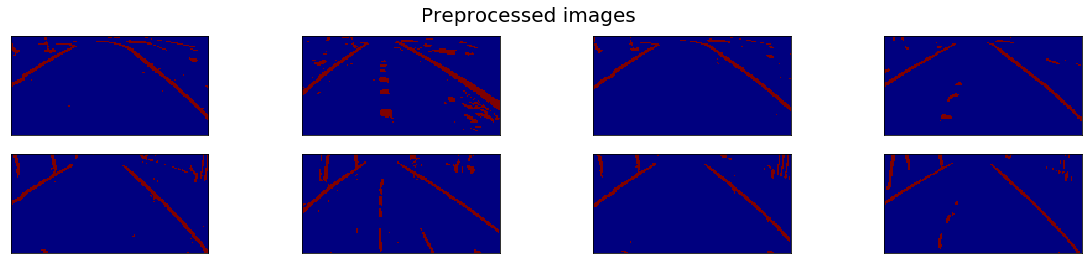

In [18]:
train_iterator = train_dataset.make_one_shot_iterator()

preprocessed_images = tf.compat.v1.Session().run(train_iterator.get_next())[:4]
plot_images(preprocessed_images, "Preprocessed images")

## Train VAE

## Compile the model

In [6]:
vae = create_variational_auto_encoder(
    input_shape=tf.compat.v1.data.get_output_shapes(train_dataset)[1:],
    latent_dim=latent_dim
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer, loss=custom_vae_loss(vae))

In [12]:
latent_dim

32

In [ ]:
mlflow.set_experiment("variational_auto_encoder")
# Create temp directory
run_tempdir = tempfile.mkdtemp()

with mlflow.start_run():
    mlflow.log_params({
        "images": str(image_folders),
        "nb_images": n_samples,
        "epochs": n_epochs,
        "batch_size": batch_size,
        "input_shape": tf.compat.v1.data.get_output_shapes(train_dataset)[1:],
        "latent_dim": latent_dim
    })
    mlflow.tensorflow.autolog()
    vae.fit(train_dataset, epochs=n_epochs, steps_per_epoch=int(n_samples / batch_size))
    # save encoder and lite encoder
    # as keras model
    encoder = tf.keras.Model(inputs=vae.get_layer("encoder").input, 
                             outputs=vae.get_layer("encoder").get_layer("z_mean").output)
    mlflow.keras.log_model(encoder, "encoder", include_optimizer=False)
    # TODO: TFLiteConverter reset tf graph, it creates issues if you want to continue to use this notebook afterwards
    # TODO: find a solution
    # as lite
    #encoder_save_path = os.path.join(run_tempdir, "encoder")
    #encoder.save(encoder_save_path + ".h5")
    #converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(encoder_save_path + ".h5")
    #converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    #encoder_tflite = converter.convert()
    #open(encoder_save_path + ".tflite", "wb+").write(encoder_tflite)
    #mlflow.log_artifact(encoder_save_path + ".tflite")

## Test VAE

In [ ]:
train_iterator = train_dataset.make_one_shot_iterator()

preprocessed_images = tf.compat.v1.Session().run(train_iterator.get_next())[:4]
plot_images(preprocessed_images, "Preprocessed images")
decoded_images = vae.predict(preprocessed_images)
plot_images(decoded_images, "Decoded images")

In [ ]:
# Load vae mlflow
#vae = mlflow.keras.load_model("runs:/1882ffed18594d8abba5239f106f7efe/model", compile=False)